In [1]:
import numpy as np 
import pandas as pd 
import sys
from decimal import ROUND_HALF_UP, Decimal
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None) 

# 导入数据

In [2]:
stock_prices = pd.read_csv('../input/jpx-tokyo-stock-exchange-prediction/train_files/stock_prices.csv')
# secondary_stock_prices = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/train_files/secondary_stock_prices.csv")
supplemental_prices = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/supplemental_files/stock_prices.csv")
# supplemental_secondary_stock_prices = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/supplemental_files/secondary_stock_prices.csv")
stock_list = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/stock_list.csv")
# financials = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/train_files/financials.csv")

# 数据预处理(EDA)

In [3]:
#查看个股时间跨度和数量
def unique_df(df):
    
    n_dates = df['Date'].nunique()
    date_min, date_max = df['Date'].min(), df['Date'].max()
    n_stocks = df['SecuritiesCode'].nunique()
    
    print(f"日期数量及范围: {n_dates} 【{date_min} --{date_max}】\n"
      f"股票个数: {n_stocks}")

In [4]:
# unique_df(stock_prices)
# unique_df(secondary_stock_prices)
# unique_df(supplemental_prices)
# unique_df(supplemental_secondary_stock_prices)
# unique_df(financials)

原数据时间跨度为【2017-01-04 --2021-12-03】

补充数据时间跨度为【2021-12-06 --2022-06-24】

公司财务状况数据时间跨度为【2017-01-04 --2021-12-03】

In [5]:
#合并2017-2022核心股票和二级股票的数据
# stock_prices = pd.concat([stock_prices,secondary_stock_prices], axis=0)
stock_prices = pd.concat([stock_prices,supplemental_prices], axis=0)
# stock_prices = pd.concat([stock_prices,supplemental_secondary_stock_prices], axis=0)
# del secondary_stock_prices
del supplemental_prices
# del supplemental_secondary_stock_prices

## 公司基本面数据

In [6]:
# def financials_p(df):
    
#     #去掉公司财务状况中证券代码缺失的数据
#     df.drop(df[df['SecuritiesCode'].isnull()].index, inplace=True)
    
#     fin_features=['Date','SecuritiesCode','NetSales','OperatingProfit','OrdinaryProfit','Profit','EarningsPerShare','TotalAssets','Equity',
#     'EquityToAssetRatio','BookValuePerShare','ResultDividendPerShareAnnual','ForecastDividendPerShareAnnual','ForecastNetSales','ForecastOperatingProfit',
#     'ForecastOrdinaryProfit','ForecastProfit','ForecastEarningsPerShare','ApplyingOfSpecificAccountingOfTheQuarterlyFinancialStatements',
#     'MaterialChangesInSubsidiaries','ChangesBasedOnRevisionsOfAccountingStandard','NumberOfIssuedAndOutstandingSharesAtTheEndOfFiscalYearIncludingTreasuryStock',
#     'NumberOfTreasuryStockAtTheEndOfFiscalYear','AverageNumberOfShares']
    
#     df=df[fin_features]
    
#     return df

# from sklearn.preprocessing import OrdinalEncoder
# def stock_p(df):
    
#     cat_features=['SecuritiesCode','NewMarketSegment','Section/Products', '33SectorCode','17SectorCode','NewIndexSeriesSizeCode','Universe0']
#     df['NewMarketSegment']=df['NewMarketSegment'].fillna('other')
#     df=df[cat_features]   
#     encoder = OrdinalEncoder()
#     df[cat_features] = encoder.fit_transform(df[cat_features])
#     df[cat_features]=df[cat_features].astype(int)
#     return df

# def basis_fill(df):
    
#     df.sort_values(by=['SecuritiesCode','Date'],axis=0,ascending=True,inplace=True)
    
#     df.replace('－', np.nan, inplace=True)

#     fill_features=['NetSales','OperatingProfit','OrdinaryProfit','Profit','EarningsPerShare','TotalAssets','Equity',
#     'EquityToAssetRatio','BookValuePerShare','ResultDividendPerShareAnnual','ForecastDividendPerShareAnnual','ForecastNetSales','ForecastOperatingProfit',
#     'ForecastOrdinaryProfit','ForecastProfit','ForecastEarningsPerShare','ApplyingOfSpecificAccountingOfTheQuarterlyFinancialStatements',
#     'MaterialChangesInSubsidiaries','ChangesBasedOnRevisionsOfAccountingStandard','NumberOfIssuedAndOutstandingSharesAtTheEndOfFiscalYearIncludingTreasuryStock',
#     'NumberOfTreasuryStockAtTheEndOfFiscalYear','AverageNumberOfShares']

#     to_float=['NetSales','OperatingProfit','OrdinaryProfit','Profit','EarningsPerShare','TotalAssets','Equity',
#     'EquityToAssetRatio','BookValuePerShare','ResultDividendPerShareAnnual','ForecastDividendPerShareAnnual','ForecastNetSales','ForecastOperatingProfit',
#     'ForecastOrdinaryProfit','ForecastProfit','ForecastEarningsPerShare']
#     to_int=['SecuritiesCode','NumberOfIssuedAndOutstandingSharesAtTheEndOfFiscalYearIncludingTreasuryStock','NumberOfTreasuryStockAtTheEndOfFiscalYear','AverageNumberOfShares']

#     for i in fill_features:
#         df[i].fillna(method='bfill',inplace=True)
#         df[i].fillna(method='ffill',inplace=True)
   
#     df[to_int]= df[to_int].astype(int)
#     df[to_float]=df[to_float].astype(float)
   

#     return df

In [7]:
#取出类型变量
# cat_features=['Section/Products', '33SectorCode','17SectorCode','NewIndexSeriesSizeCode','NewMarketSegment']
# financials=financials_p(financials)
# stock_list=stock_p(stock_list)

In [8]:
#合并数据集,并填充基本面数据
# stock_prices = pd.merge(stock_prices,stock_list,on="SecuritiesCode",how="left")
# stock_prices = pd.merge(stock_prices,financials,on=["SecuritiesCode",'Date'],how="left")
# del stock_list,financials
# stock_prices=basis_fill(stock_prices)

## 股价数据

In [9]:
#删除Close和Target同时缺失的样本和列ID
stock_prices.drop(stock_prices[stock_prices['Target'].isnull()& stock_prices["Target"].isnull()].index, inplace=True)
stock_prices.drop('RowId', axis=1, inplace=True)
# stock_prices=stock_prices[stock_prices.Date>='2021-01-01']

# 定义时序数据处理核心函数
## 包括复权函数、因子衍生函数

In [10]:
#复权函数
def adj_close(df):
    
    df = df.sort_values("Date", ascending=False)
    df.loc[:, "CumulativeAdjustmentFactor"] = df["AdjustmentFactor"].cumprod()
    df.loc[:, "AdjustedClose"] = (df["CumulativeAdjustmentFactor"] * df["Close"]).map(lambda x: float(Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP)))
    df.loc[:, "AdjustedOpen"] = (df["CumulativeAdjustmentFactor"] * df["Open"]).map(lambda x: float(Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP)))
    df.loc[:, "AdjustedHigh"] = (df["CumulativeAdjustmentFactor"] * df["High"]).map(lambda x: float(Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP)))
    df.loc[:, "AdjustedLow"] = (df["CumulativeAdjustmentFactor"] * df["Low"]).map(lambda x: float(Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP)))
    
    df = df.sort_values("Date")
    #
    df.loc[df["AdjustedClose"] == 0, "AdjustedClose"] = np.nan
    df.loc[df["AdjustedOpen"] == 0, "AdjustedOpen"] = np.nan
    df.loc[df["AdjustedHigh"] == 0, "AdjustedHigh"] = np.nan
    df.loc[df["AdjustedLow"] == 0, "AdjustedLow"] = np.nan
  
    df.loc[:, "AdjustedClose"] = df.loc[:, "AdjustedClose"].ffill()
    df.loc[:, "AdjustedOpen"] = df.loc[:, "AdjustedOpen"].ffill()
    df.loc[:, "AdjustedHigh"] = df.loc[:, "AdjustedHigh"].ffill()
    df.loc[:, "AdjustedLow"] = df.loc[:, "AdjustedLow"].ffill()
    
#     df.drop("Close", axis=1, inplace=True)
#     df.drop("Open", axis=1, inplace=True)
#     df.drop("High", axis=1, inplace=True)
#     df.drop("Low", axis=1, inplace=True)
    return df

def adjust_price(df):
  
    df = df.copy()
    df.loc[: ,"Date"] = pd.to_datetime(df.loc[: ,"Date"], format="%Y-%m-%d")

    df = df.sort_values(["SecuritiesCode", "Date"])
    df = df.groupby("SecuritiesCode").apply(adj_close).reset_index(drop=True)

    return df

def drop_orignal(df):

    df.drop("Close", axis=1, inplace=True)
    df.drop("Open", axis=1, inplace=True)
    df.drop("High", axis=1, inplace=True)
    df.drop("Low", axis=1, inplace=True)
    df.drop('AdjustmentFactor', axis=1, inplace=True)
    df.drop('CumulativeAdjustmentFactor', axis=1, inplace=True)

def compute_bias(close, window):                                                                 
    return (close - close.rolling(window).mean()) / close.rolling(window).mean()

def compute_rsi(close, window):
    diff = close.diff()
    diff = diff.iloc[1:]
    up = diff.where(diff > 0, 0)
    down = -diff.where(diff < 0, 0)
    ma_up = up.rolling(window).mean()
    ma_down = down.rolling(window).mean()
    rs = ma_up / ma_down
    rsi = 100 - (100 / (1 + rs))
    return rsi

def compute_hsl(close, high, low, window):
    mid = (high + low + close) / 3
    hsl = pd.Series((close - mid) / (0.5 * (high - low)), name='hsl')
    return hsl.rolling(window).mean()

def compute_amo(close, window):
    amo = (close - close.rolling(window).mean()).rolling(6).sum()
    return amo
    
def compute_atr(high, low, close, window):
    tr = high.combine(low, min).combine(close.shift(), max) - low.combine(close.shift(), min).combine(high.shift(), max)
    atr = tr.rolling(window).mean()
    return atr

def compute_cmo(close, window):
    diff = close.diff()
    diff = diff.iloc[1:]
    ma1 = diff.where(diff > 0, 0).rolling(window).sum()
    ma2 = (-diff.where(diff < 0, 0)).rolling(window).sum()
    cmo = (ma1 - ma2) / (ma1 + ma2) * 100
    return cmo

def compute_amv(close, volume, window):
    amv = ((close - close.shift(1)) / close.shift(1) * volume).rolling(window).sum()
    return amv

def compute_bbi(close, ma1, ma2, ma3, ma4, window):
    bbi = (close.rolling(ma1).mean() + close.rolling(ma2).mean() + close.rolling(ma3).mean() + close.rolling(ma4).mean()) / 4
    return bbi.rolling(window).mean()

def compute_boll(close, window, k):
    mid = close.rolling(window).mean()
    std = close.rolling(window).std()
    upper = mid + k * std
    lower = mid - k * std
    return pd.DataFrame({'boll_upper': upper, 'boll_mid': mid, 'boll_lower': lower})

def compute_mass(close, volume, window):
    mass_index = pd.Series(0.0, index=close.index)
    ema_high = close.ewm(span=window, min_periods=window - 1).mean()
    ema_low = close.ewm(span=window, min_periods=window - 1).mean()
    range = ema_high - ema_low
    ex1 = range.ewm(span=window, min_periods=window - 1).mean()
    ex2 = ex1.ewm(span=window, min_periods=window - 1).mean()
    mass = ex1 / ex2
    mass_index.iloc[window * 2 - 1:] = mass.rolling(window).sum()
    return mass_index   
    
    
    
    
    
    
def all_alpha_factors(df):

    # 计算动量
    df['PM1'] = df.groupby("SecuritiesCode")['AdjustedClose'].pct_change(periods=1).bfill() # 前一天的变化率
    df['PM5'] = df.groupby("SecuritiesCode")['AdjustedClose'].pct_change(periods=5).bfill()# 前五天的变化率
    df['PM10'] = df.groupby("SecuritiesCode")['AdjustedClose'].pct_change(periods=10).bfill() # 前十天的变化率
    df['PM20'] = df.groupby("SecuritiesCode")['AdjustedClose'].pct_change(periods=20).bfill() # 前二十天的变化率
    df['PM30'] = df.groupby("SecuritiesCode")['AdjustedClose'].pct_change(periods=30).bfill() # 前三十天的变化率
    df['alpha_PM']=  (df['PM1']+ df['PM5']+ df['PM10']+ df['PM20']+ df['PM30'])/5

    # 计算波动性
    df['volatility'] = (df.groupby("SecuritiesCode")['AdjustedClose'].apply(lambda x: x.rolling(window=50).std() / x.rolling(window=50).mean()).reset_index(level=0, drop=True)).bfill()
    df['stand_5'] =df.groupby('SecuritiesCode')['AdjustedClose'].apply(lambda x: x.rolling(window=5).std()).reset_index(drop=True).bfill()
    df['stand_10'] =df.groupby('SecuritiesCode')['AdjustedClose'].apply(lambda x: x.rolling(window=10).std()).reset_index(drop=True).bfill()
    df['stand_20'] =df.groupby('SecuritiesCode')['AdjustedClose'].apply(lambda x: x.rolling(window=20).std()).reset_index(drop=True).bfill()
    
    # 计算对数回报率
    df['returns'] = df.groupby("SecuritiesCode")['AdjustedClose'].apply(lambda x: np.log(x / x.shift(1))).bfill()
    
    # 计算移动平均
    df['sma5'] = (df.groupby("SecuritiesCode")['AdjustedClose'].rolling(window=5).mean()).reset_index(drop=True).bfill()
    df['sma10'] = (df.groupby("SecuritiesCode")['AdjustedClose'].rolling(window=10).mean()).reset_index(drop=True).bfill()
    df['sma20'] = (df.groupby("SecuritiesCode")['AdjustedClose'].rolling(window=20).mean()).reset_index(drop=True).bfill()
    df['sma30'] = (df.groupby("SecuritiesCode")['AdjustedClose'].rolling(window=30).mean()).reset_index(drop=True).bfill()

    # 计算5天EMA指数移动平均线 
    df['ema5'] = (df.groupby("SecuritiesCode")['AdjustedClose'].ewm(span=5, adjust=False).mean()).reset_index(drop=True).bfill()
    # 计算10天EMA指数移动平均线
    df['ema10'] = (df.groupby("SecuritiesCode")['AdjustedClose'].ewm(span=10, adjust=False).mean()).reset_index(drop=True).bfill()
    # 计算20天EMA指数移动平均线
    df['ema20'] = (df.groupby("SecuritiesCode")['AdjustedClose'].ewm(span=20, adjust=False).mean()).reset_index(drop=True).bfill()
    # 计算30天EMA指数移动平均线
    df['ema30'] = (df.groupby("SecuritiesCode")['AdjustedClose'].ewm(span=30, adjust=False).mean()).reset_index(drop=True).bfill()



    #计算14天ATR真实波幅 
    df['atr_14'] = df.groupby('SecuritiesCode').apply(lambda x: compute_atr(x['AdjustedHigh'], x['AdjustedLow'], x['AdjustedClose'], 14)).reset_index(drop=True).bfill()                                                              
                                                                        
                                                                    
    # 计算21天CMO（动量震荡器）
    df['cmo_21'] = df.groupby('SecuritiesCode')['AdjustedClose'].apply(lambda x: compute_cmo(x, 21)).reset_index(drop=True).bfill()
   
    
    # 计算BIAS指标
    df['bias_5'] = df.groupby('SecuritiesCode')['AdjustedClose'].apply(lambda x: compute_bias(x, 5)).reset_index(drop=True).bfill()
                                                              

    # 计算RSI指标
    df['rsi_14'] = df.groupby('SecuritiesCode')['AdjustedClose'].apply(lambda x: compute_rsi(x, 14)).reset_index(drop=True).bfill()

   
    # 计算HSL指标
    df['hsl_5'] = df.groupby('SecuritiesCode').apply(lambda x: compute_hsl(x['AdjustedClose'], x['AdjustedHigh'], x['AdjustedLow'], 5)).reset_index(drop=True).bfill()


    # 计算AMO指标
    df['amo_6'] = df.groupby('SecuritiesCode')['AdjustedClose'].apply(lambda x: compute_amo(x, 6)).reset_index(drop=True).bfill()
    
                                                                                                                                         
    # 计算AMV指标                                                               
    df['amv_7'] = df.groupby('SecuritiesCode').apply(lambda x: compute_amv(x['AdjustedClose'], x['Volume'], 7)).reset_index(drop=True).bfill()
                                                                        

    # 计算BBI指标
    df['bbi_3_6_9_12'] = df.groupby('SecuritiesCode')['AdjustedClose'].apply(lambda x: compute_bbi(x, 3, 6, 9, 12, 7)).reset_index(drop=True).bfill()
                                                                        

#     计算BOLL带
#     boll_df = df.groupby('SecuritiesCode')['AdjustedClose'].apply(lambda x: compute_boll(x, 20, 2)).reset_index(drop=True).bfill()
#     df = df.join(boll_df[['boll_upper','boll_mid','boll_lower']])
    
#     计算MASS指标
#     df['mass_5'] = df.groupby('SecuritiesCode').apply(lambda x: compute_mass(x['AdjustedClose'], x['Volume'], 5)).reset_index(drop=True).bfill()

    return df


def clean(df):
    
    #转换日期格式
    df['Date']=pd.to_datetime(df['Date'],format='%Y-%m-%d')
    
    #按日期升序排列
    df=df.sort_values(by='Date',axis=0,ascending=True,inplace=False)
    
    #发放股利记为1，不发放记为0
    df["ExpectedDividend"] = df["ExpectedDividend"].mask(df["ExpectedDividend"] > 0, 1)
    
    #向前向后填充价格
    df['Close'].fillna(method='ffill', inplace=True)
    df['Close'].fillna(method='bfill', inplace=True)
    df['Open'].fillna(method='ffill', inplace=True)
    df['Open'].fillna(method='bfill', inplace=True)
    df['High'].fillna(method='ffill', inplace=True)
    df['High'].fillna(method='bfill', inplace=True)
    df['Low'].fillna(method='ffill', inplace=True)
    df['Low'].fillna(method='bfill', inplace=True)
    
    #计算复权收盘价
    df=adjust_price(df)

    
    return df


#夏普比率
def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2) -> float:
 
    def _calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
       
        assert df['Rank'].min() == 0
        assert df['Rank'].max() == len(df['Rank']) - 1
        weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
        purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
        short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
        return purchase - short

    buf = df.groupby('Date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio
   
    

## 取横截面个股批量处理

In [11]:
temp = stock_prices.groupby("SecuritiesCode").apply(clean).reset_index(drop=True)
stock_prices_alpha = all_alpha_factors(temp)
import gc
gc.collect()

0

# 模型训练(基于十折滚动交叉验证的LightGBM模型)

In [12]:
stock_prices_alpha['Date'] = pd.to_datetime(stock_prices_alpha['Date'])
stock_prices_alpha=stock_prices_alpha.sort_values(['Date','SecuritiesCode'])
stock_prices_alpha_drop = stock_prices_alpha.copy()
drop_orignal(stock_prices_alpha_drop)
stock_prices_alpha_drop['Date'] = stock_prices_alpha_drop['Date'].dt.strftime('%Y%m%d').astype(int)

In [13]:
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit

sharpe_ratio=[]

tscv_fold = TimeSeriesSplit(n_splits=10, gap=8000)

stock_prices_alpha_drop.dropna().sort_values(['Date','SecuritiesCode'],ascending=True,inplace=True)

X = stock_prices_alpha_drop.drop(['Target'], axis=1)
y = stock_prices_alpha_drop['Target'].to_numpy()


for fold,(train_index, eval_index) in enumerate(tscv_fold.split(X, y)):
    
    X_train_fold,y_train_fold = X.iloc[train_index,:], y[train_index]
        
    X_val_fold, y_val_fold = X.iloc[eval_index,:], y[eval_index]
    
    print("训练集日期范围: {} -- {}".format(X_train_fold.Date.min(),X_train_fold.Date.max()))
    print("验证集日期范围: {} -- {}".format(X_val_fold.Date.min(),X_val_fold.Date.max()))
    
    # 创建训练集和测试集
    train_set = lgb.Dataset(X_train_fold.drop(['Date'], axis=1), label=y_train_fold,categorical_feature = ['SecuritiesCode'])
        
    eval_set = lgb.Dataset(X_val_fold.drop(['Date'], axis=1), label=y_val_fold,categorical_feature = ['SecuritiesCode'])

    params = {
        'learning_rate': 0.08,
        'objective': 'regression_l1',
        'boosting': 'gbdt',
        'random_state': 13,
        'verbosity': 1,
        'metric': 'mae',
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'n_jobs': -1,
        'force_col_wise':True
     }
    
    model = lgb.train(params = params, 
                train_set = train_set, 
                valid_sets = [train_set, eval_set], 
                num_boost_round = 3000, 
                early_stopping_rounds=25)  

    y_pred = model.predict(X_val_fold.drop(['Date'], axis=1))
    rank=[]
    val_dates=X_val_fold.Date.unique()[1:-1]
    X_val_df=X_val_fold[X_val_fold.Date.isin(val_dates)]
    
    for i in X_val_df.Date.unique():
        temp_df = X_val_df[X_val_df.Date == i]
        temp_df["pred"] = model.predict(temp_df.drop(['Date'], axis=1))
        temp_df["Rank"] = (temp_df["pred"].rank(method="first", ascending=False)-1).astype(int)
        rank.append(temp_df["Rank"].values)

    stock_rank=pd.Series([x for y in rank for x in y], name="Rank")
    
    sharpe_df=pd.concat([X_val_df.reset_index(drop=True),stock_rank,stock_prices_alpha_drop[stock_prices_alpha_drop.Date.isin(val_dates)]['Target'].reset_index(drop=True)], axis=1)
    sharpe=calc_spread_return_sharpe(sharpe_df)
    sharpe_ratio.append(sharpe)
    print("验证集夏普比率: {}".format(sharpe))
    
    gc.collect()
    
print("\n交叉验证夏普比率均值: {:.4f}, 标准差 = {:.2f}.".format(np.mean(sharpe_ratio),np.std(sharpe_ratio)))

训练集日期范围: 20170104 -- 20170630
验证集日期范围: 20170706 -- 20180112
[LightGBM] [Info] Total Bins 10017
[LightGBM] [Info] Number of data points in the train set: 228554, number of used features: 35
[1]	training's l1: 0.0119466	valid_1's l1: 0.0122303
Training until validation scores don't improve for 25 rounds
[2]	training's l1: 0.011936	valid_1's l1: 0.0122301
[3]	training's l1: 0.0119246	valid_1's l1: 0.0122301
[4]	training's l1: 0.0119158	valid_1's l1: 0.0122314
[5]	training's l1: 0.0119103	valid_1's l1: 0.0122308
[6]	training's l1: 0.0119024	valid_1's l1: 0.0122307
[7]	training's l1: 0.0118947	valid_1's l1: 0.0122308
[8]	training's l1: 0.0118899	valid_1's l1: 0.012231
[9]	training's l1: 0.0118828	valid_1's l1: 0.0122308
[10]	training's l1: 0.0118762	valid_1's l1: 0.0122317
[11]	training's l1: 0.0118703	valid_1's l1: 0.0122326
[12]	training's l1: 0.0118663	valid_1's l1: 0.0122332
[13]	training's l1: 0.0118628	valid_1's l1: 0.0122333
[14]	training's l1: 0.0118575	valid_1's l1: 0.0122336
[15]	

输入全部数据重新训练

In [14]:
X_train=stock_prices_alpha_drop.drop(['Target'], axis=1)
y_train= stock_prices_alpha_drop['Target']
from lightgbm import LGBMRegressor
model = LGBMRegressor(**params).fit(X_train.drop(['Date'], axis=1), y_train)

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Total Bins 8420
[LightGBM] [Info] Number of data points in the train set: 2602014, number of used features: 35


In [15]:
gc.collect()

81

## 特征重要性可视化

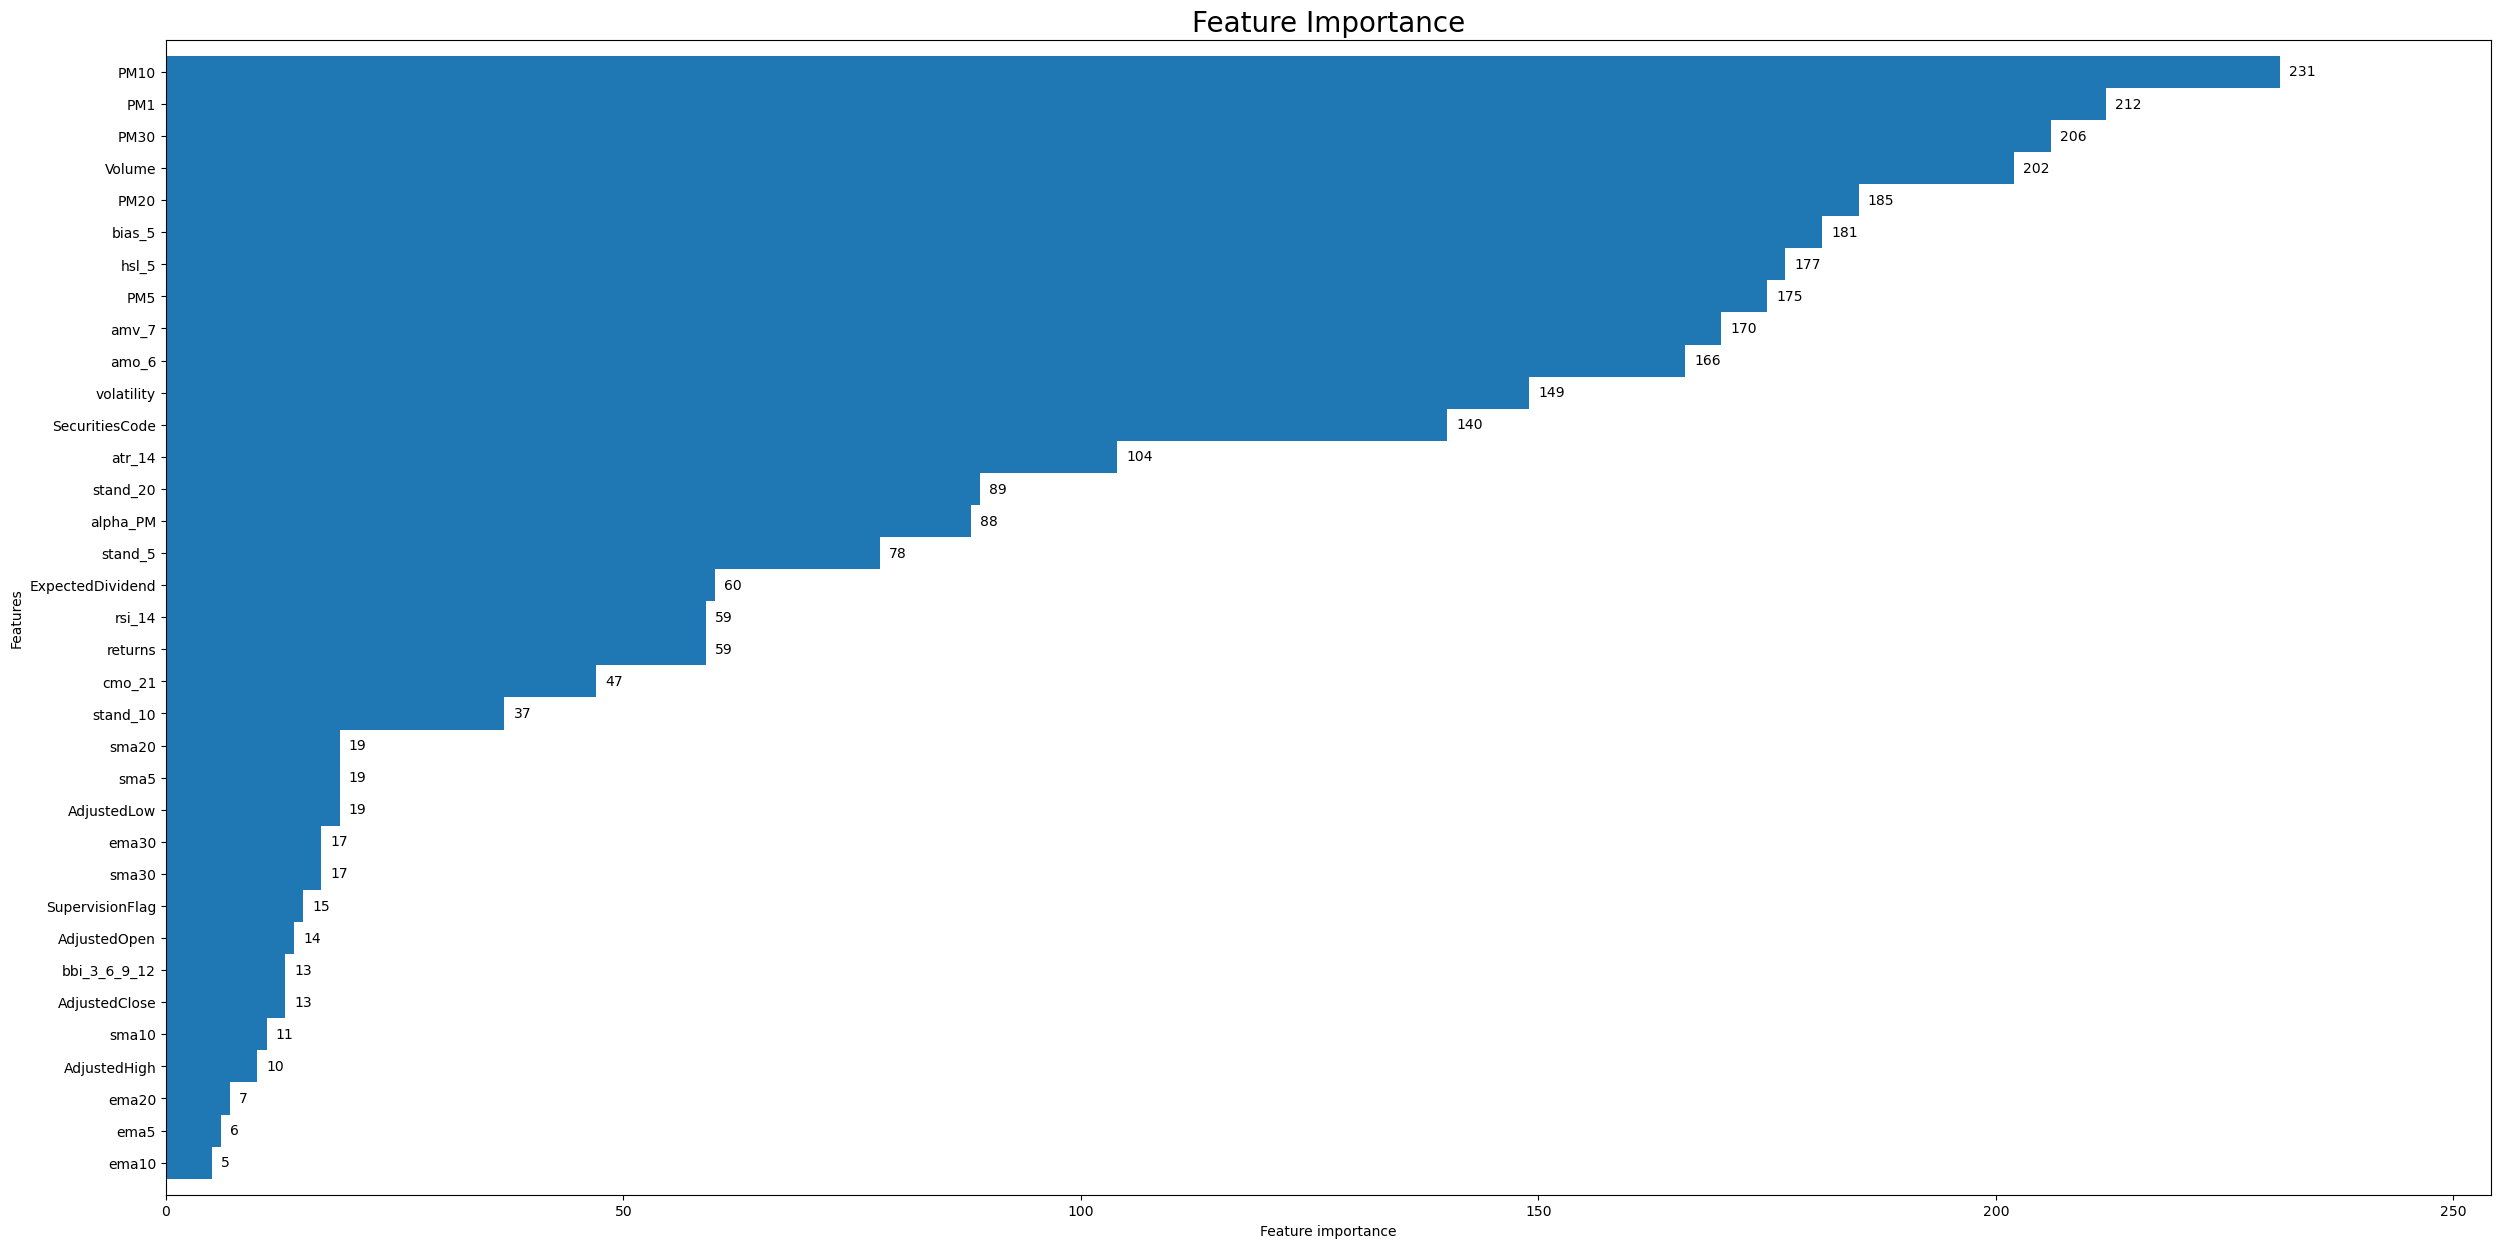

In [16]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(30,15))
lgb.plot_importance(model, height=1, ax=ax)
ax.grid(False)
plt.title("Feature Importance", fontsize=20)
plt.show()

In [17]:
import jpx_tokyo_market_prediction
env = jpx_tokyo_market_prediction.make_env()  
iter_test = env.iter_test()   

In [18]:
history = stock_prices_alpha.drop('Target', axis=1)
del stock_prices_alpha
cols=['Date','SecuritiesCode','Open','High','Low','Close','Volume','AdjustmentFactor','ExpectedDividend','SupervisionFlag']
history=history[history.Date>='2022-02-01'][cols]
history['Date']=pd.to_datetime(history['Date']).dt.strftime('%Y%m%d')

counter = 0
for (prices, options, financials, trades, secondary_prices, sample_prediction) in iter_test:
    
    x_test = pd.DataFrame()
    
    #取出prices中的股票代码
    pool = prices['SecuritiesCode'].unique().tolist()
    
    #去掉测试数据的ID
    prices.drop('RowId', axis=1, inplace=True)

    #转换日期格式
    prices['Date']=pd.to_datetime(prices['Date']).dt.strftime('%Y%m%d')
    
    #记录日期
    current_date = prices["Date"].iloc[0]
    
    prices["ExpectedDividend"] = prices["ExpectedDividend"].mask(prices["ExpectedDividend"] > 0, 1)
    
    if counter == 0:
        history = history.loc[history["Date"] < current_date]
    
    #把测试数据和历史数据贴在一起，形成连续的时间序列以便于衍生因子
    history=pd.concat([history, prices], axis=0).reset_index(drop=True)
    
    #升序排列
    history.sort_values(['SecuritiesCode','Date'],ascending=True,inplace=True)
    
    #调整价格
    temp = history.groupby("SecuritiesCode").apply(clean).reset_index(drop=True)
    
    #衍生因子
    history = all_alpha_factors(temp)
    
    #构建测试集
    x_test = history[(history.Date == current_date)&(history.SecuritiesCode.isin(pool))]
    
    x_test['Date'] = x_test ['Date'].dt.strftime('%Y%m%d').astype(int)
    
    drop_orignal(x_test)
    
    y_pred = model.predict(x_test.drop(['Date'], axis=1))
    
    x_test['y_pred'] = y_pred
    
    #偏好于发放股利的股票
    x_test.loc[:, "predict"] =  x_test['y_pred']+ x_test["ExpectedDividend"]+x_test['alpha_PM']

    y_pred= x_test["predict"].tolist()
    
    y_pred = np.array(y_pred)
#     y_pred = model.predict(x_test)

    print(f'预测结果: {y_pred}')
    order = y_pred.argsort()
    y_pred = order.argsort()#把预测结果转换成收益率排名

    sample_prediction['Rank'] = y_pred
    
    #检查正确性
    assert sample_prediction["Rank"].notna().all()
    assert sample_prediction["Rank"].min() == 0
    assert sample_prediction["Rank"].max() == len(sample_prediction["Rank"]) - 1
    
    env.predict(sample_prediction)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
预测结果: [nan nan nan ... nan nan nan]
预测结果: [nan nan nan ... nan nan nan]
